In [12]:
# Importation des bibliothèques nécessaires pour la manipulation des données, la visualisation et la modélisation
import pandas as pd  # Manipulation de données
import numpy as np  # Opérations mathématiques
import matplotlib.pyplot as plt  # Visualisation de base
import seaborn as sns  # Visualisation avancée
import re  # Manipulation des chaînes avec expressions régulières
import utils
from utils import *

# Importation des modules nécessaires pour le machine learning
from sklearn.multioutput import MultiOutputRegressor  # Gère la régression pour des sorties multiples
from sklearn.linear_model import LinearRegression  # Modèle de régression linéaire
import xgboost as xgb  # Bibliothèque d'amplification
from sklearn.metrics import mean_squared_error  # Calcul de l'erreur quadratique moyenne

# Suppression des avertissements futurs pour une meilleure lisibilité
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Traitement des Données

In [13]:
# Chargement des données
data = pd.read_csv('regularite-mensuelle-tgv-aqst.csv', sep=';')

In [14]:
# Fonction pour traiter les colonnes 'date' et 'service'
def date_service_proccess(df):
    df[['année', 'mois']] = df['date'].str.split('-', expand=True) 
    df = df.drop(columns =['date'])

    # Convertir en entier
    df['année'] = df['année'].astype(int)
    df['mois'] = df['mois'].astype(int)

    # Traitement de la variable catégorielle 'service'
    df = pd.get_dummies(df, columns=['service'], dtype=int)
    return df

# Fonction pour diviser les données en données d'entraînement de te test
def split_data(df):

    X = df.drop(columns =['retard_moyen_arrivee', 'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
				'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs'])

    y1 = df[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',
			'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]
    return X, y1

In [15]:
# Transformation des colonnes 'gare_depart' et 'gare_arrivee' en variables numériques
data = pd.get_dummies(data, columns=['gare_depart', 'gare_arrivee'], dtype=int)

# Séparation des données en ensembles d'entraînement et de test
test_data = utils.select_test_data(data)
train_data = utils.select_train_data(data, test_data)

# Traitement et division de l'ensemble d'entraînement
X_train, y_train = split_data(date_service_proccess(train_data))

# Suppression des commentaires 
X_train = X_train.drop(columns=['commentaire_annulation', 'commentaires_retard_arrivee', 'commentaire_retards_depart'])


y_pred_train_xgb = pd.read_csv('y_pred_train_xgb.csv', header=None)

y0_train_pred = pd.DataFrame(y_pred_train_xgb)
y0_train_pred.columns = ['retard_moyen_arrivee'] 

# Combinaison des variables indépendantes et de la variable dépendante 'retard_moyen_arrivee' 
X_train = pd.concat([X_train, y0_train_pred], axis=1)

# Traitement et division de l'ensemble de test

X_test, y_test = split_data(date_service_proccess(test_data))

# Suppression des colonnes inutiles
X_test = X_test.drop(columns=['commentaire_annulation', 'commentaires_retard_arrivee', 'commentaire_retards_depart'])


y_pred_xgb = pd.read_csv('y_pred_xgb.csv', header=None)

y0_test_pred = pd.DataFrame(y_pred_xgb)
y0_test_pred.columns = ['retard_moyen_arrivee'] 

X_test = X_test.reset_index(drop=True)
# Combinaison des variables indépendantes et de la variable dépendante 'retard_moyen_arrivee' 
X_test = pd.concat([X_test, y0_test_pred], axis=1)

# Réinitialisation des index de y_test
y_test = y_test.reset_index()
y_test = y_test.drop(columns=["index"])


C:\Users\abdel\AppData\Local\Temp\ipykernel_46708\524769301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['année', 'mois']] = df['date'].str.split('-', expand=True)
C:\Users\abdel\AppData\Local\Temp\ipykernel_46708\524769301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['année', 'mois']] = df['date'].str.split('-', expand=True)


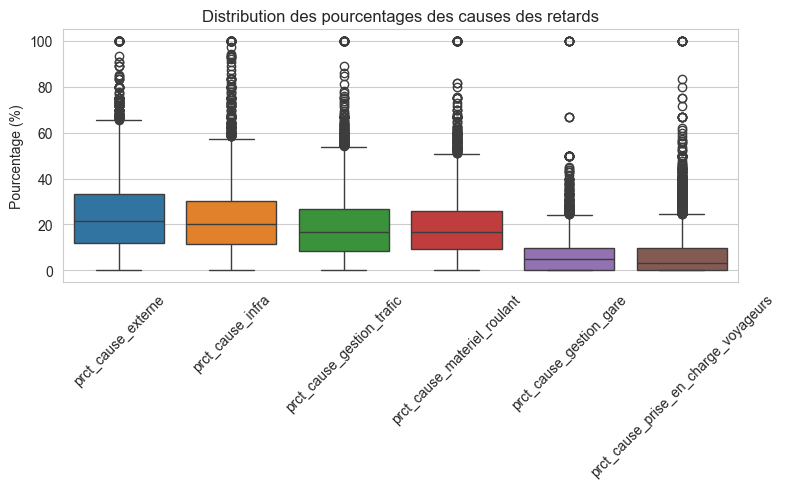

In [31]:
# Set the style for the plots
sns.set_style("whitegrid")

# Create boxplots for each cause of delay
plt.figure(figsize=(8, 5))
sns.boxplot(y_train)
plt.title("Distribution des pourcentages des causes des retards")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Nous séparons la variable cible 'prct_cause_prise_en_charge_voyageurs' des autres variables cibles. La raison est que nous souhaitons utiliser un modèle différent pour prédire cette variable spécifique par rapport aux autres variables cibles.

In [16]:
y_train1 = y_train.drop(columns='prct_cause_prise_en_charge_voyageurs')
y_train2 = y_train['prct_cause_prise_en_charge_voyageurs']
y_test1 =  y_test.drop(columns='prct_cause_prise_en_charge_voyageurs')
y_test2 = y_test['prct_cause_prise_en_charge_voyageurs']

 Nous définissons une série de listes contenant les noms des colonnes à supprimer de nos ensembles de données X_train et X_test. Chaque liste ajoute des colonnes supplémentaires à supprimer par rapport à la précédente. Ceci est fait dans le but de tester différentes combinaisons de caractéristiques et de voir laquelle offre les meilleures performances avec nos modèles.

In [17]:
remove_columns_1 =  ['retard_moyen_tous_trains_arrivee']
remove_columns_2 = remove_columns_1 + ['nb_train_retard_sup_15' , 'retard_moyen_trains_retard_sup15' , 'nb_train_retard_sup_30' , 'nb_train_retard_sup_60']
remove_columns_3 = remove_columns_2 + ['nb_train_retard_arrivee']
remove_columns_4 = remove_columns_3 + ['nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']
remove_columns_5 = remove_columns_4 + ['nb_annulation']
L_remove = [remove_columns_1, remove_columns_2, remove_columns_3, remove_columns_4, remove_columns_5]

### Modélisation

Application d'une série de modélisations en utilisant différentes niveaux de réstriction. Pour chaque niveau (définie par les colonnes à supprimer dans L_remove), nous formons deux modèles : un modèle de régression linéaire pour prédire plusieurs sorties (y_train1) et un modèle XGBoost pour prédire la variable y_train2.

Après avoir prédit avec les deux modèles, nous combinons leurs prédictions pour obtenir la prédiction finale. Ensuite, nous normalisons les prédictions afin que la somme des prédictions pour chaque observation soit égale à 100% (représentant des pourcentages).

Enfin, nous calculons la racine de l'erreur quadratique moyenne (RMSE) entre les prédictions combinées et les valeurs réelles, et ajoutons cette valeur à notre matrix_rmce.

In [18]:
matrix_rmce=[]

# Boucle sur chaque configuration de caractéristiques définie dans L_remove
for r in L_remove:
    # Suppression des colonnes spécifiées pour la configuration actuelle
    X_train2 = X_train.drop(columns=r)
    X_test2 = X_test.drop(columns=r)

    # Modèle de régression linéaire pour plusieurs sorties
    model1 = MultiOutputRegressor(LinearRegression())
    model1.fit(X_train2, y_train1)
    y_pred1 = model1.predict(X_test2)
    y_train_pred1 = model1.predict(X_train2)

    # Modèle XGBoost
    params ={'subsample': 0.5, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}
    model2 = xgb.XGBRegressor(objective='reg:squarederror', **params)
    model2.fit(X_train2, y_train2)
    y_pred2 = model2.predict(X_test2)
    y_train_pred2 = model2.predict(X_train2)

    # Conversion des prédictions en DataFrames et combinaison des deux modèles
    y_pred1, y_pred2 = pd.DataFrame(y_pred1), pd.DataFrame(y_pred2)
    y_train_pred1, y_train_pred2 = pd.DataFrame(y_train_pred1), pd.DataFrame(y_train_pred2)
    y_pred = pd.concat([y_pred1, y_pred2], axis=1)
    y_train_pred = pd.concat([y_train_pred1, y_train_pred2], axis=1)

    # Nommer les colonnes des prédictions selon les colonnes de y_test
    y_pred.columns = y_test.columns
    y_train_pred.columns = y_test.columns

    # Normalisation des prédictions
    y_pred['sum'] = y_pred.sum(axis=1)
    for col in y_pred.columns[:-1]:
        y_pred[col] = y_pred[col] * 100 / y_pred['sum']
    y_pred.drop('sum', axis=1, inplace=True)

    # Calcul de la RMSE pour la configuration actuelle
    rmse = mean_squared_error(y_test, y_pred, multioutput='raw_values', squared=False)
    matrix_rmce.append(rmse)

matrix_rmce = np.array(matrix_rmce)


### Visualisation

Visualisation les erreurs (RMCE) obtenues pour chaque configuration de colonnes retirées.

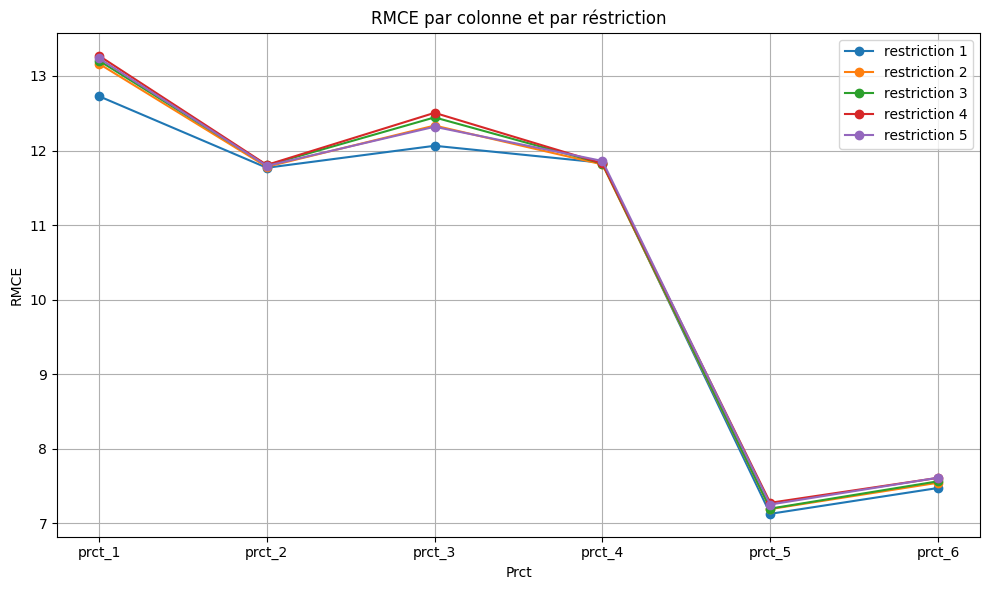

In [19]:
import matplotlib.pyplot as plt

# Abscisses pour le graphique
abscisses = ["prct_1", "prct_2", "prct_3", "prct_4", "prct_5", "prct_6"]

# Initialisation du graphe
plt.figure(figsize=(10, 6))

# Tracer chaque ligne de l'erreur pour chaque configuration de restriction
for index, ligne in enumerate(matrix_rmce):
    plt.plot(abscisses, ligne, label=f'restriction {index + 1}', marker='o')

# Ajout des titres et des labels
plt.title("RMCE par colonne et par réstriction")
plt.xlabel("Prct")
plt.ylabel("RMCE")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Affichage du graphique
plt.show()


In [20]:
y_pred.head()

,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,20.220460,11.227165,19.487961,29.729326,11.572778,7.762311
1,17.003782,23.936514,17.173804,27.043900,10.322108,4.519892
2,29.605895,17.604217,17.360039,19.812236,7.603051,8.014562
3,31.309017,8.522524,34.502895,12.284027,5.660227,7.721311
4,28.825506,15.206774,30.810195,10.381427,7.245941,7.530157


Visualisation la distribution des erreurs pour chaque colonne cible dans notre ensemble de données. Cela nous aide à comprendre comment notre modèle se comporte par rapport à chaque cible et à identifier si des erreurs systématiques ou des biais sont présents.

Distibution des erreurs d'<u>entrainemant</u>

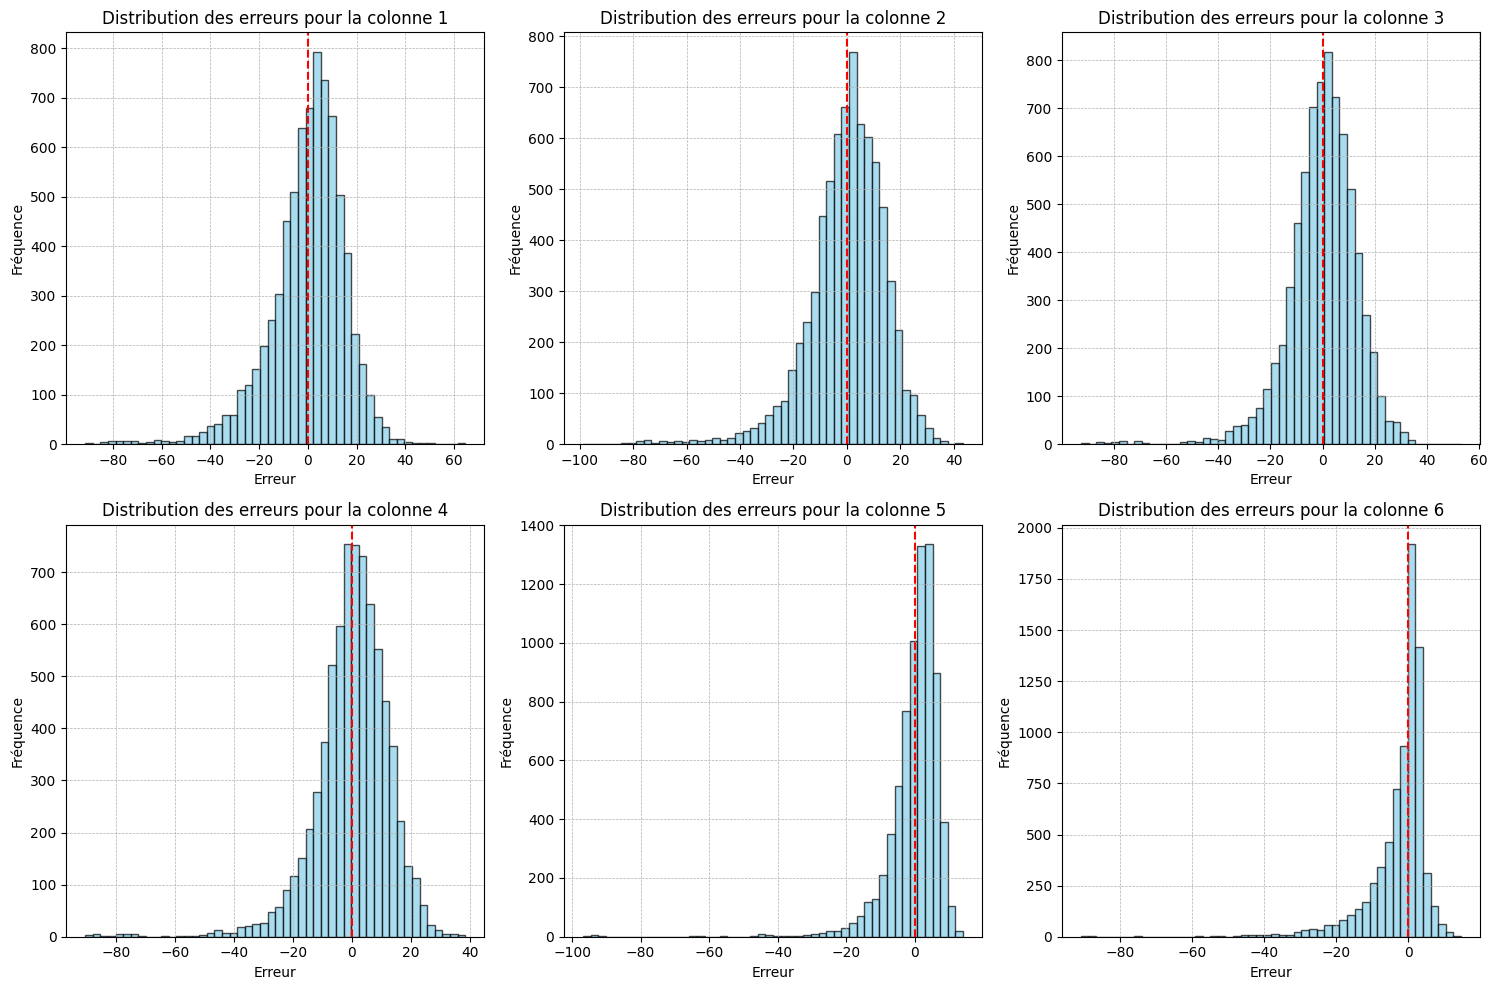

In [21]:
errors = (y_train_pred - y_train)

# Identifier les colonnes contenant des NaN
nan_columns = errors.columns[errors.isnull().any()].tolist()


# Remplacer les NaN par zéro
errors.fillna(0, inplace=True)


# Création des histogrammes pour chaque colonne
n_columns = errors.shape[1]
plt.figure(figsize=(15, 10))

for i in range(n_columns):
    plt.subplot(2, 3, i+1)  # supposant que vous avez 6 colonnes, donc 2x3 sous-graphiques
    plt.hist(errors.iloc[:, i], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    plt.title(f'Distribution des erreurs pour la colonne {i + 1}')
    plt.xlabel('Erreur')
    plt.ylabel('Fréquence')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)  # ligne pour erreur = 0

plt.tight_layout()
plt.show()




Distibution des erreurs de <u>test</u> 

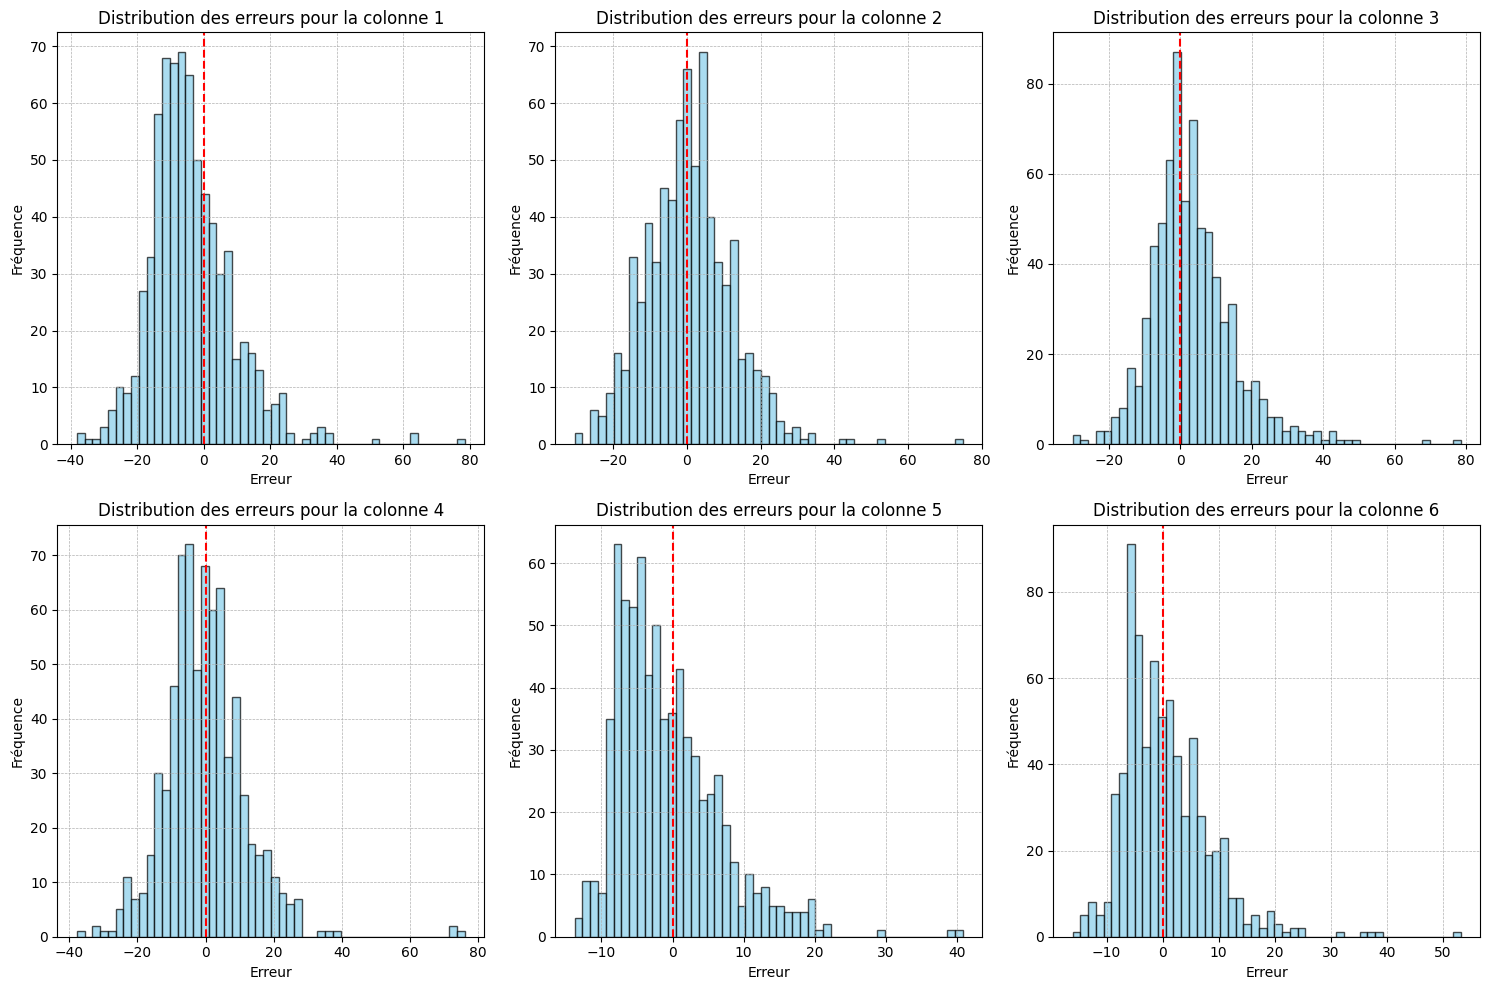

In [22]:
errors = (y_test - y_pred)

# Identifier les colonnes contenant des NaN
nan_columns = errors.columns[errors.isnull().any()].tolist()


# Remplacer les NaN par zéro
errors.fillna(0, inplace=True)


# Création des histogrammes pour chaque colonne
n_columns = errors.shape[1]
plt.figure(figsize=(15, 10))

for i in range(n_columns):
    plt.subplot(2, 3, i+1)
    plt.hist(errors.iloc[:, i], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    plt.title(f'Distribution des erreurs pour la colonne {i + 1}')
    plt.xlabel('Erreur')
    plt.ylabel('Fréquence')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)  # ligne pour erreur = 0

plt.tight_layout()
plt.show()